# Argon Emission Spectrum
Predicting the emission spectrum of Argon LSP to determine the plasma temperature

## Analysis of Xenon spectrum
Comparing the emission lines of Xenon to the LSP spectrum measured by Zimakov et al. [1]

In [1]:
from dotenv import load_dotenv
load_dotenv()
from os import getenv
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from PIL import Image
import numpy as np
import Spectra.spectrum as sp
from datamanager import shotlist
from Laser import util as lu
from scipy.optimize import curve_fit
from scipy.constants import k, elementary_charge


kB = k

DATAPATH = getenv('DATAPATH')

def pullEmissionLineData(specie):
    cachePath = '../cachedata/{}Spectrum.csv'.format(specie)
    try:
        lines = pd.read_html(  # This fails sometimes...
            'https://physics.nist.gov/PhysRefData/Handbook/Tables/{}table2.htm'.format(
                specie
            ),
            match='Air'
            )[1]
        # Some cleanup
        lines.dropna(axis=0, how='all', inplace=True)
        lines.dropna(axis=1, how='all', inplace=True)
        lines['Intensity'] = lines['Intensity'].map(
            lambda s: s.rstrip(' Phls'))
        lines['Intensity'] = pd.to_numeric(lines['Intensity'])
        lines.to_csv(cachePath)
    except:
        print('Warning - {}: Could not access data from NIST, falling back to cache...'.format(specie))
        lines = pd.read_csv(cachePath, index_col=0)
    return lines

argonLines = pullEmissionLineData('argon')
xenonLines = pullEmissionLineData('xenon')

Warning - argon: Could not access data from NIST, falling back to cache...
Warning - xenon: Could not access data from NIST, falling back to cache...


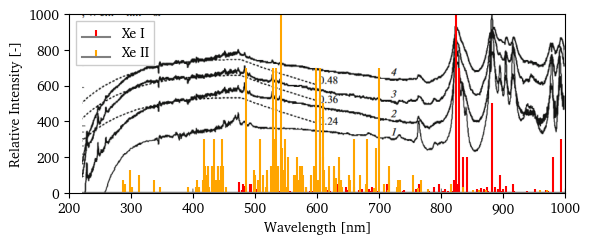

In [2]:
xenonLines['Wavelength [nm]'] = xenonLines['Air Wavelength (Å)']/10
XeILines = xenonLines[xenonLines['Spectrum'] == 'Xe I']
XeIILines = xenonLines[xenonLines['Spectrum'] == 'Xe II']
# ArILines = argonLines[argonLines['Spectrum'] == 'Ar I']
# ArIILines = argonLines[argonLines['Spectrum'] == 'Ar II']

zimakovData = np.asarray(Image.open('../rawdata/zimakov.png'))
plt.imshow(zimakovData, extent=(220, 1000, 0, 1000))
# plt.stem(ArILines['Wavelength [nm]'], ArILines['Intensity'], label='Ar I',
#          linefmt='red', markerfmt='', basefmt='grey')
# plt.stem(ArIILines['Wavelength [nm]'], ArIILines['Intensity'], label='Ar II',
#          linefmt='orange', markerfmt='', basefmt='grey')
plt.stem(XeILines['Wavelength [nm]'], XeILines['Intensity'], label='Xe I',
         linefmt='red', markerfmt='', basefmt='grey')
plt.stem(XeIILines['Wavelength [nm]'], XeIILines['Intensity'], label='Xe II',
         linefmt='orange', markerfmt='', basefmt='grey')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Intensity [-]')
plt.xlim(200, 1000)
ax = plt.gca()
ax.set_aspect((265/736)*(800/1000))
plt.legend(loc='upper left')
plt.show()

## Analysis of Argon spectrum
Zimakov et al. [1] unfortunately did not provide the measured spectrum of their Argon LSP. Lu et al. provide their measured spectrum sustained by a 1080 nm laser.

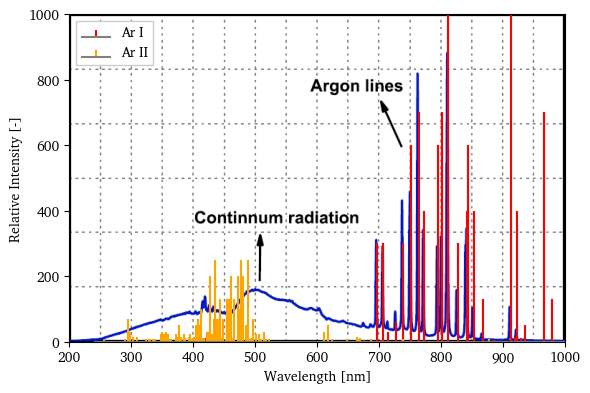

In [3]:
argonLines['Wavelength [nm]'] = argonLines['Air Wavelength (Å)']/10
ArILines = argonLines[argonLines['Spectrum'] == 'Ar I']
ArIILines = argonLines[argonLines['Spectrum'] == 'Ar II']

luData = np.asarray(Image.open('../rawdata/lu_argon.png'))
plt.imshow(luData, extent=(200, 1000, 0, 1000))
plt.stem(ArILines['Wavelength [nm]'], ArILines['Intensity'], label='Ar I',
         linefmt='red', markerfmt='', basefmt='grey')
plt.stem(ArIILines['Wavelength [nm]'], ArIILines['Intensity'], label='Ar II',
         linefmt='orange', markerfmt='', basefmt='grey')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Intensity [-]')
plt.xlim(200, 1000)
ax = plt.gca()
ax.set_aspect((457/692)*(800/1000))
plt.legend(loc='upper left')
plt.show()

# Analyzing our spectra
Let's explore our spectral data, starting by plotting a few spectra at varying laser powers and pressure conditions

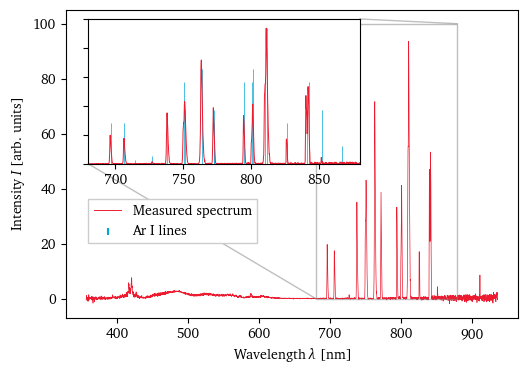

In [4]:
linecycler = cycler(linestyle=['-', '--', '-.', ':'])
# plt.rc('axes', prop_cycle=linecycler)

p20shots = {
    'LSP50_X7': None,  # 100 %
    # 'LSP52_S2': None,  # 80 %
    # 'LSP53_S3': None,  # 67 %
    # 'LSP54_S4': None,  # 50 %
    # 'LSP56_S6': None   # 33 %
}

p10shots = {
    # 'LSP60_S9': None,   # 100 %
    # 'LSP61_S10': None,  # 80 %
    # 'LSP63_S12': None,  # 67 %
    # 'LSP64_S13': None,  # 50 %
}

maxval = 0

fig_p, ax_p = plt.subplots(figsize=(5.84, 4))
for shotset, lcolor in zip([p20shots, p10shots], ['#ED1B2F', '#00A6D6']):
    for shotID in shotset.keys():
        spectrumPath = sp.get_filepath_from_ID(shotID)
        s = sp.Spectrum(spectrumPath, trimL=48, trimR=600)
        s.calibrate_irradiance(2800,
                            '../rawdata/spectra/calibration/Halogen_Light.txt',
                            '../rawdata/spectra/calibration/Halogen_Dark.txt')
        shotset[shotID] = s
        maxv = s.counts.max()
        maxval = maxv if maxv > maxval else maxval
        ax_p.plot(s.wavelengths, s.counts, color=lcolor,
                # label='{:.1f} %'.format(shotlist.loc[shotID]['Laser Setpoint']*100), 
                label='Measured spectrum', 
                zorder=2.5, linewidth=0.5)

scalefactor = maxval/ArILines['Intensity'].max()
# ax_p.stem(ArILines['Wavelength [nm]'], ArILines['Intensity']*scalefactor,
#           label='Ar I emission lines', linefmt='C1', markerfmt='', basefmt='None')
# for xi, yi in zip(ArILines['Wavelength [nm]'], ArILines['Intensity']*scalefactor):
#     if yi > 0.05*maxval: 
#         ax_p.annotate('{:.2f}'.format(xi), xy=(xi, yi), xycoords='data',
#                       xytext=(0, 3), textcoords='offset points', 
#                       fontfamily='monospace', fontsize='x-small', ha='center',
#                       va='bottom', rotation='vertical')
ax_p.set_xlabel(r'Wavelength $\lambda$ [nm]')
ax_p.set_ylabel('Intensity $I$ [arb. units]')
# ax_p.legend()
ax_inset = ax_p.inset_axes([0.05, 0.5, 0.6, 0.47], xlim=(680, 880), 
                           ylim=(0,100), yticklabels=[])
ax_inset.plot(s.wavelengths, s.counts, color='C0',
                label='Measured spectrum', 
                zorder=2.5, linewidth=0.7)
stems = ax_inset.stem(ArILines['Wavelength [nm]'], ArILines['Intensity']*scalefactor,
           label='Ar I lines', linefmt='C1', markerfmt='', 
           basefmt='None')
stems.stemlines.set(linewidth=0.5)
ax_inset.legend(loc=(0, -0.55))
ax_p.indicate_inset_zoom(ax_inset)
# ax_p.set_xlim((680, 880))
fig_p.savefig('../report/assets/5 results/spectrum_LSP50_X7_lines.png',
              dpi=72)
fig_p.savefig('../report/assets/5 results/spectrum_LSP50_X7_lines.pdf')
# ax_p.set_xlim((800, 805))
    

It appears several Ar I lines consistently show up clearly on the spectrogram, namely:
- 696.5 nm
- 706.7 nm
- 738.4 nm
- 763.5 nm
- 794.8 nm
- 826.5 nm

The above make suitable candidate for the Boltzmann plot method of temperature determination, as they show up clearly, consistently, and are fairly isolated from neighboring lines.

## Boltzmann Plot method
Given a level transition from level $k$ down to level $i$:
```
E_k --------
        |
        |~~~~> \lambda_{ki}
        |
        v
E_i --------
```

This generates an emission line at wavelength $\lambda_{ki}$, with intensity $\epsilon_{ki}$, transition probability $A_{ki}$, and degeneracy for level $k$ of $g_k$, the following equation can be derived to relate these parameters to plasma temperature $T$:
$$
    \frac{\epsilon_{ki}\lambda_{ki}}{A_{ki}g_k} = \frac{hcN}{4\pi Z(T)}\exp{\left(-\frac{E_k}{k_\mathrm{B}T}\right)}
$$
Where $h$ is the Planck constant, $c$ is the speed of light, $N$ is the atomic number density, $Z(T)$ is the partition function, and $k_\mathrm{B}$ is the Boltzmann constant. This equation can be linearized with respect to $E_k$ by taking the natural log of both sides:
$$
    \ln{\frac{\epsilon_{ki}\lambda_{ki}}{A_{ki}g_k}} = -\frac{E_k}{k_\mathrm{B}T} + \ln{\frac{hcN}{4\pi Z(T)}}
$$
The second term is a constant for a given temperature, so $E_k$ can be plotted against $\ln{(\epsilon_{ki}\lambda_{ki}/A_{ki}g_k)}$ resulting (in theory) in a straight line with gradient $-1/k_\mathrm{B}T$. This can then be used to evaluate $T$.

However, $\epsilon_{ki}\lambda_{ki}/A_{ki}g_k$ is not dimensionless! There are several methods to resolve this, but we will focus on one that can be used with relative spectrometry (i.e. our spectrometry data). This ratio can be normalized by using a reference transition $r$:

$$
    \left[\frac{\epsilon_{ki}\lambda_{ki}}{A_{ki}g_k}\right]_r = \frac{hcN_r}{4\pi Z_r(T)}\exp{\left(-\frac{E_k}{k_\mathrm{B}T}\right)_r}
$$

Multiplying either side of the original equation by the reciprocal of the above, then linearizing, yields the following, with the constant term bundled as $C$:

$$
    \ln{\left(\frac{\epsilon_{ki}\lambda_{ki}}{A_{ki}g_k}\left[\frac{A_{ki}g_k}{\epsilon_{ki}\lambda_{ki}}\right]_r\right)} = \frac{-E_k+[E_k]_r}{k_\mathrm{B}T} + C
$$

Line [nm]    Observed [nm]   Value [-]   Index [-]
   696.54           696.21       38.32        1677
   706.72           706.39       34.70        1730
   738.40           738.19       80.17        1897
   763.51           763.21      205.75        2030
   794.82           794.43       58.66        2198
   826.45           826.08       24.66        2371
Estimated temperature: 5180.2 K


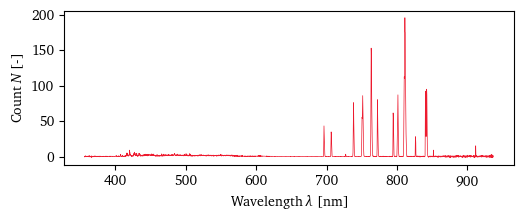

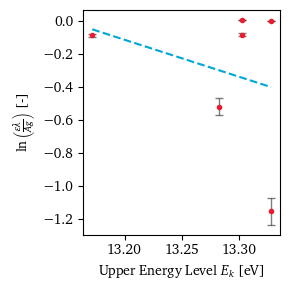

In [6]:
transitions_all = np.loadtxt(DATAPATH+'Spectra/transitiondb/ArITransitions.csv',
                         delimiter=',', skiprows=1)
subset = [0,1,2,5,6,9]
# subset = [0,1,2]
# subset = [2,5,6]
transitions = transitions_all[subset,:]
# transitions = transitions_all
# t_subset = None
ID = 'LSP60_S9'
spectrumPath = sp.get_filepath_from_ID(ID)
# spectrumPath = "E:\Spectra\calibration\Mercury-Argog_Spectrum.txt"
# spectrumPath = '../rawdata/spectra/testspectrum2.csv'
s = sp.Spectrum(spectrumPath, trimL=48, trimR=600)
# s = sp.Spectrum(spectrumPath, calibrate=False, raw=True)
s.calibrate_irradiance(2800,
                        '../rawdata/spectra/calibration/Halogen_Light.txt',
                        '../rawdata/spectra/calibration/Halogen_Dark.txt')
# s.counts *= 10
# s.counts += 1

f, a = s.plot()
f.set_size_inches(5.8, 2)

observed_lines = s.find_lines(transitions[:,0], array=True, 
                              integrate=True, 
                              verbose=True, 
                              voigt=True)
ref_wavelength = 763.51
# ref_wavelength = 696.54
ref_line_index = observed_lines[:,0] == ref_wavelength
ref_line = observed_lines[ref_line_index, :].reshape((4,))
ref_term = transitions[transitions[:,0] == ref_wavelength, 1] \
            / (ref_line[2]*ref_wavelength)
lnvalues = np.log(
    ref_term * observed_lines[:,0] * observed_lines[:,2] / transitions[:,1]
)
E_kr = transitions[transitions[:,0] == ref_wavelength, 2]

fitfunc = lambda ek, m, c: m*ek + c  # We're bundling the E_kr/kb.T term into c

popt, pcov = curve_fit(fitfunc, transitions[:,2], lnvalues)
fitfunc_x = np.array([transitions[:,2].min(), transitions[:,2].max()])
plt.subplots(figsize=(3,3))
# plt.plot(transitions[:,2], lnvalues, '.')
plt.errorbar(transitions[:,2], lnvalues, yerr=transitions[:,3]*np.abs(lnvalues),
             ecolor=(0,0,0,0.5), elinewidth=1.0, capsize=3, fmt='.')
print('Estimated temperature: {:.1f} K'.format(-elementary_charge/(kB*popt[0])))
plt.xlabel(r'Upper Energy Level $E_k$ [eV]')
plt.ylabel(r'$\ln{\left(\frac{\epsilon\lambda}{Ag}\right)}$ [-]')
plt.plot(fitfunc_x, fitfunc(fitfunc_x, *popt), '--')
plt.tight_layout()
# plt.savefig('../report/assets/5 results/spectrum_{}_boltzmann.png'.format(ID),
#               dpi=72)
# plt.savefig('../report/assets/5 results/spectrum_{}_boltzmann.pdf'.format(ID))
plt.show()

## References
1. Zimakov, V.P., Kuznetsov, V.A., Solovyov, N.G. et al. [Interaction of near-IR laser radiation with plasma of a continuous optical discharge](https://doi.org/10.1134/S1063780X15110100). Plasma Phys. Rep. 42, 68–73 (2016). DOI: 10.1134/S1063780X15110100  
1. Q. Lu et al., [Characteristic Diagnostics of a Laser-Stabilized High-Pressure Argon Plasma by Optical Emission Spectroscopy,](https://doi.org/10.1109/TPS.2022.3172977) in IEEE Transactions on Plasma Science, vol. 50, no. 9, pp. 2578-2587, Sept. 2022, doi: 10.1109/TPS.2022.3172977.
1. Kozlov, G I, Kuznetsov, V A, & Masyukov, V A. [Radiative losses from an argon plasma and a radiation model of a continuous optical discharge.](http://www.jetp.ras.ru/cgi-bin/dn/e_039_03_0463.pdf) Zh. Eksp. Teor. Fiz. 66, 954-964 (1974)